In [1]:
import os
import utils
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2022
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
def baSpread(x):
    a=x['AP1'].values.tolist()
    b=x['BP1'].values.tolist()
    bas=np.empty(len(x))
    for i in range(len(a)):
       bas[i]=(a[i]/10**4-b[i]/10**4)#/(a[i]+b[i])*10**4
    return bas

In [3]:
lob_data=utils.caricaLOB('bynd',0.05)
ld=lob_data.values.tolist()
of=utils.OF_1(ld)
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(of, columns=bCols)
m=pd.DataFrame(utils.midPrice(lob_data),columns=['m'])
m['r']=m['m'].pct_change().fillna(0).copy()
b=pd.DataFrame(baSpread(lob_data),columns=['spread'])


In [26]:
spread=b['spread'].to_numpy()
d=np.log(b).diff().fillna(0).to_numpy().flatten()
hot=np.empty(len(d))
for i in range(0,len(hot)):
    if spread[i]>=0.15: #spread[i]-spread[i-1]>0.03:
        hot[i]=1 #se spread[i]>soglia up
    elif spread[i]<=0.03: #-spread[i-1]<0.02:
        hot[i]=2 #se spread[i]<soglia lo
    else:
        hot[i]=0
#plt.plot(hot);

In [5]:
np.quantile(spread,0.9), np.quantile(spread,0.1)

(0.15000000000000568, 0.030000000000001137)

In [27]:
c=0
d=0
for i in range(len(spread)):
    if spread[i]<=0.03:
        c=c+1
    elif spread[i]>=0.15:
        d=d+1
c,d

(13130, 16190)

In [7]:
stats.mode(b)

ModeResult(mode=array([[0.05]]), count=array([[13518]]))

In [28]:
hot,spread

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.05, 0.05, 0.1 , ..., 0.11, 0.07, 0.11]))

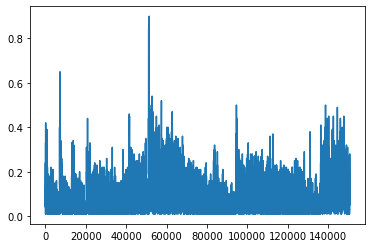

In [9]:
plt.plot(spread)

CNN-LSTM Classifier
===

In [29]:
def prepare_x_y(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6,1)

    Y = np_utils.to_categorical(y.astype(int),3)

    return X,Y

In [30]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX,trainY = prepare_x_y  (n_train)    
valiX ,valiY  = prepare_x_y  (n_vali )    
testX ,testY  = prepare_x_y  (n_test )   


print(trainX.shape ,trainY.shape)
print(valiX.shape  ,valiY .shape)
print(testX.shape  ,testY .shape)

(90368, 100, 6, 1) (90368, 3)
(30056, 100, 6, 1) (30056, 3)
(30056, 100, 6, 1) (30056, 3)


In [31]:
testY

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [32]:

def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])#

    return model
checkpoint_filepath = './model_tensorflow2/weights_class'
deeplob = create_nn(100, 6, 64)
deeplob.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 100, 3, 32)   96          ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 100, 3, 32)   0           ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 100, 3, 32)   4128        ['leaky_re_lu_9[0][0]']          
                                                                                            

In [33]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [34]:
#deeplob.load_weights('modelMSFTClassification.h5')
simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=50, batch_size=256,callbacks=[callback,saving])

Epoch 1/50
353/353 [==============================] - 162s 453ms/step - loss: 0.6765 - accuracy: 0.8011 - val_loss: 0.5370 - val_accuracy: 0.8479
Epoch 2/50
353/353 [==============================] - 158s 447ms/step - loss: 0.6207 - accuracy: 0.8070 - val_loss: 0.5371 - val_accuracy: 0.8479
Epoch 3/50
353/353 [==============================] - 158s 448ms/step - loss: 0.6081 - accuracy: 0.8070 - val_loss: 0.5357 - val_accuracy: 0.8478
Epoch 4/50
353/353 [==============================] - 159s 450ms/step - loss: 0.5912 - accuracy: 0.8070 - val_loss: 0.5582 - val_accuracy: 0.8478
Epoch 5/50
353/353 [==============================] - 163s 463ms/step - loss: 0.5817 - accuracy: 0.8070 - val_loss: 0.5474 - val_accuracy: 0.8478
Epoch 6/50
353/353 [==============================] - 170s 482ms/step - loss: 0.5748 - accuracy: 0.8070 - val_loss: 0.5427 - val_accuracy: 0.8478
Epoch 7/50
353/353 [==============================] - 184s 522ms/step - loss: 0.5662 - accuracy: 0.8069 - val_loss: 0.5396 -

In [35]:
P = deeplob.predict(testX)
pj= np.round(P)
P

940/940 [==============================] - 26s 27ms/step


array([[0.82089174, 0.01676698, 0.16234127],
       [0.8489159 , 0.02137606, 0.129708  ],
       [0.86919683, 0.05291688, 0.07788635],
       ...,
       [0.6996854 , 0.25909686, 0.04121775],
       [0.76602113, 0.18501753, 0.04896135],
       [0.7654877 , 0.18708366, 0.04742873]], dtype=float32)

In [36]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY, axis=1), np.argmax(pj, axis=1)))
print(classification_report(np.argmax(testY, axis=1), np.argmax(pj, axis=1), digits=4))

accuracy_score: 0.758151450625499
              precision    recall  f1-score   support

           0     0.7590    0.9983    0.8624     22814
           1     0.2895    0.0021    0.0042      5232
           2     0.0769    0.0005    0.0010      2010

    accuracy                         0.7582     30056
   macro avg     0.3751    0.3336    0.2892     30056
weighted avg     0.6317    0.7582    0.6554     30056



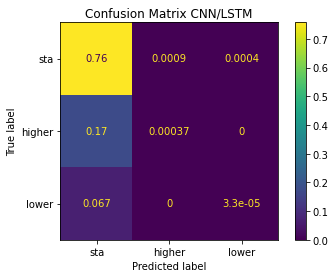

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sta','higher','lower'])
disp.plot()
disp.ax_.set_title("Confusion Matrix CNN/LSTM");

LSTM classifier
===

In [38]:
def prepare_x_y_lstm(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6)

    
    Y = np_utils.to_categorical(y.astype(int),3)

    return X,Y

In [39]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX_lstm,trainY_lstm = prepare_x_y_lstm  (n_train)    
valiX_lstm,valiY_lstm = prepare_x_y_lstm  (n_vali )    
testX_lstm,testY_lstm = prepare_x_y_lstm  (n_test )   


print(trainX_lstm.shape ,trainY_lstm .shape)
print(valiX_lstm.shape  ,valiY_lstm .shape)
print(testX_lstm.shape  ,testY_lstm .shape)

(90368, 100, 6) (90368, 3)
(30056, 100, 6) (30056, 3)
(30056, 100, 6) (30056, 3)


In [40]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.001)
loss_function = 'categorical_crossentropy'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.7)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function, metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           18176     
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 100, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 100, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 100, 64)           0   

In [41]:
#model.load_weights('classifyLSTM.h5')
lstmMSFT=model.fit(trainX_lstm, trainY_lstm, validation_data=(valiX_lstm, valiY_lstm), epochs=20, batch_size=256)

Epoch 1/20
353/353 [==============================] - 300s 837ms/step - loss: 0.6110 - accuracy: 0.8073 - val_loss: 0.5461 - val_accuracy: 0.8479
Epoch 2/20
353/353 [==============================] - 283s 802ms/step - loss: 0.5673 - accuracy: 0.8106 - val_loss: 0.5685 - val_accuracy: 0.8452
Epoch 3/20
353/353 [==============================] - 293s 829ms/step - loss: 0.5408 - accuracy: 0.8156 - val_loss: 0.5579 - val_accuracy: 0.8456
Epoch 4/20
353/353 [==============================] - 293s 829ms/step - loss: 0.5146 - accuracy: 0.8199 - val_loss: 0.5995 - val_accuracy: 0.8238
Epoch 5/20
353/353 [==============================] - 290s 823ms/step - loss: 0.4931 - accuracy: 0.8238 - val_loss: 0.5831 - val_accuracy: 0.8318
Epoch 6/20
353/353 [==============================] - 290s 822ms/step - loss: 0.4738 - accuracy: 0.8292 - val_loss: 0.6040 - val_accuracy: 0.8237
Epoch 7/20
353/353 [==============================] - 290s 821ms/step - loss: 0.4553 - accuracy: 0.8326 - val_loss: 0.5969 -

In [42]:
np.mean(spread)

0.08080408542246986

In [43]:
P_lstm = model.predict(testX_lstm)
p_lstmj= np.round(P_lstm)
P_lstm

940/940 [==============================] - 21s 22ms/step


array([[7.3153925e-01, 8.0850162e-04, 2.6765224e-01],
       [7.4636018e-01, 1.3052745e-03, 2.5233456e-01],
       [7.5357813e-01, 5.3160783e-04, 2.4589024e-01],
       ...,
       [7.9417193e-01, 1.9710822e-01, 8.7198680e-03],
       [5.6409639e-01, 4.3204212e-01, 3.8615037e-03],
       [6.6264969e-01, 3.3399460e-01, 3.3557087e-03]], dtype=float32)

In [44]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1)))
print(classification_report(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1), digits=4))

accuracy_score: 0.7346286931062017
              precision    recall  f1-score   support

           0     0.7635    0.9459    0.8449     22814
           1     0.3326    0.0835    0.1335      5232
           2     0.1339    0.0318    0.0514      2010

    accuracy                         0.7346     30056
   macro avg     0.4100    0.3537    0.3433     30056
weighted avg     0.6464    0.7346    0.6680     30056



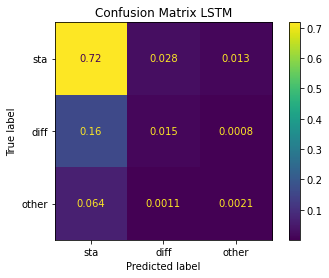

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1), normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sta','diff','other'])
disp.plot()
disp.ax_.set_title("Confusion Matrix LSTM");

Naive Gaussian Classifier
===

In [46]:
rng = np.random.RandomState(1)
X = n_train[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
y = n_train['h'].to_numpy()
Xte = n_vali[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
Yte = n_vali['h'].to_numpy()#['h'].to_numpy()
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
clf = GaussianNB()
clf.fit(X, y)
predNB = clf.predict(Xte)
encPr=np_utils.to_categorical(predNB)
#encTe=np_utils.to_categorical(Yte)
print(predNB,Yte)

[0. 0. 0. ... 0. 0. 2.] [0. 0. 0. ... 0. 0. 0.]


In [47]:
encTe=np_utils.to_categorical(n_vali['h'].to_numpy())

In [48]:
print('accuracy_score:', accuracy_score(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1)))
print(classification_report(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1), digits=4))

accuracy_score: 0.8284255206260778
              precision    recall  f1-score   support

           0     0.8487    0.9752    0.9076     25561
           1     0.0576    0.0120    0.0199      2079
           2     0.0852    0.0119    0.0209      2516

    accuracy                         0.8284     30156
   macro avg     0.3305    0.3330    0.3161     30156
weighted avg     0.7305    0.8284    0.7724     30156



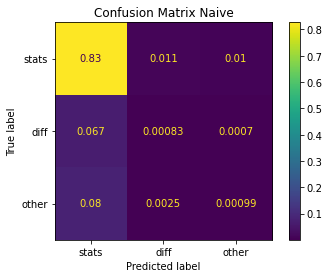

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['stats','diff','other'])
disp.plot()
disp.ax_.set_title("Confusion Matrix Naive");

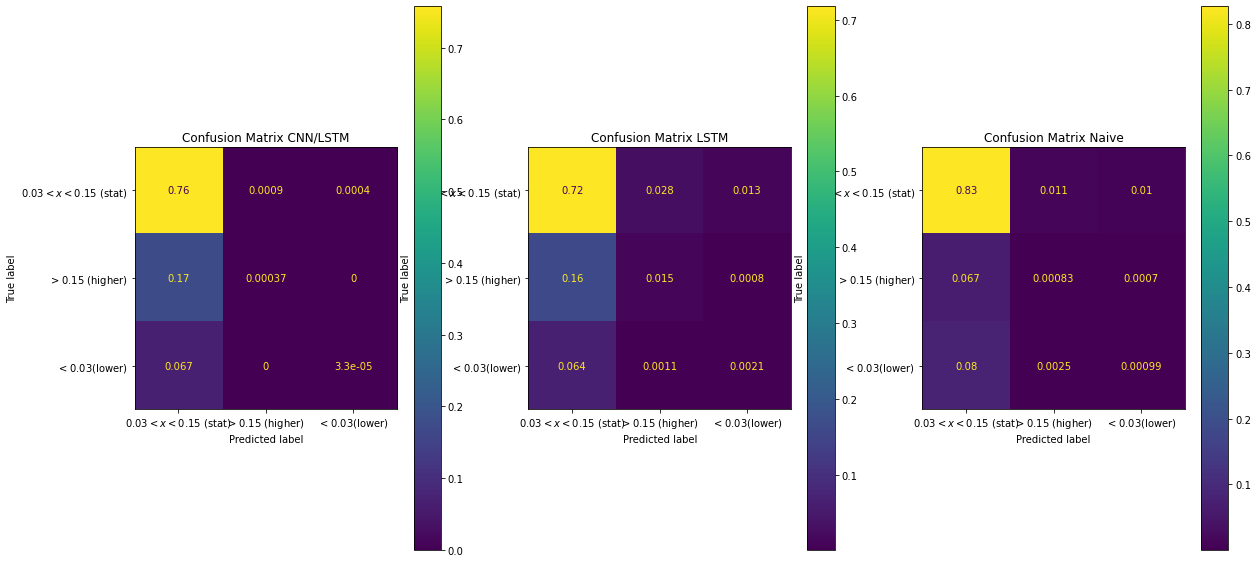

In [63]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['$0.03<x<0.15$ (stat)','$>0.15$ (higher)','$<0.03$(lower)'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='all')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['$0.03<x<0.15$ (stat)','$>0.15$ (higher)','$<0.03$(lower)'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='all')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['$0.03<x<0.15$ (stat)','$>0.15$ (higher)','$<0.03$(lower)'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive");
#plt.tight_layout()  

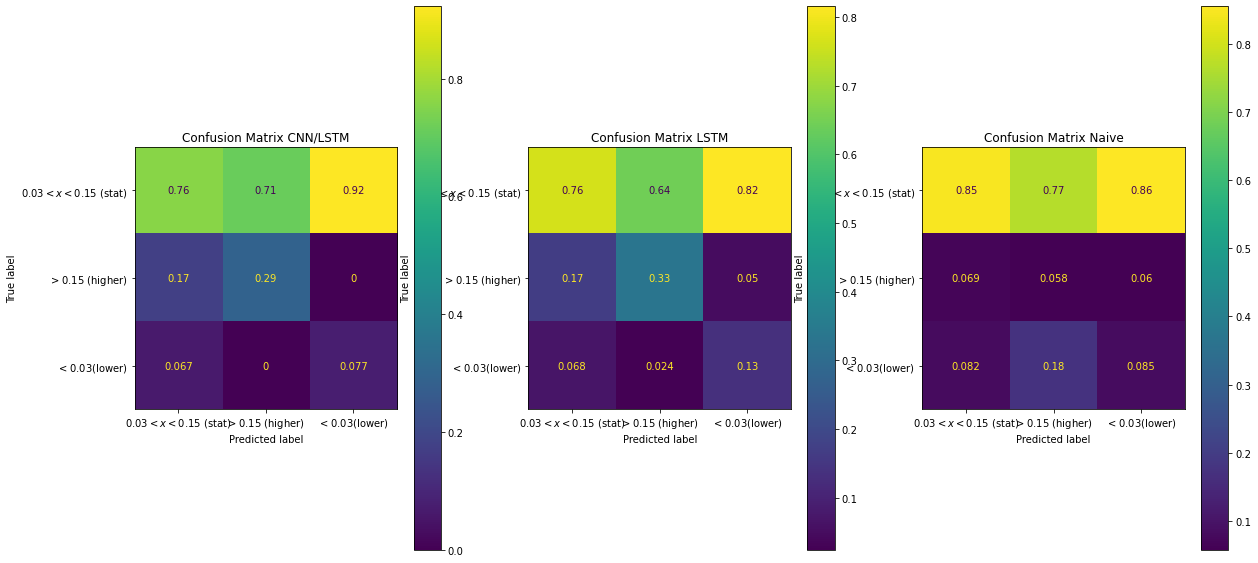

In [64]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['$0.03<x<0.15$ (stat)','$>0.15$ (higher)','$<0.03$(lower)'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['$0.03<x<0.15$ (stat)','$>0.15$ (higher)','$<0.03$(lower)'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='pred')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['$0.03<x<0.15$ (stat)','$>0.15$ (higher)','$<0.03$(lower)'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive");

1) Precision is a measure of how many of the positive predictions made are correct (true positives).
2) Accuracy describes the number of correct predictions over all predictions (TP+TN)/sizePop.
3) Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.
4) F1 provides a single metric that weights the two ratios (precision and recall) in a balanced way.
    - Very small precision or recall will result in lower overall score. Thus it helps balance the two metrics.
    - If you choose your positive class as the one with fewer samples, F1-score can help balance the metric across positive/negative samples.